## Introduction

This tutorial explains how to use Tranalyzer to extract the *bytes-per-burst* (BPB) feature from TLS encrypted YouTube video streams and recognize what video title is contained in a new test sample, or detect that it is a new video. This is an implementation of recent work by Dubin et al. [1]

## The bytes-per-burst feature

A flow is viewed as a signal of packets over time. This signal is then transformed in a series of *bursts*. A burst here is defined as the set of packets that were recorded within a certain time window of each other. (Note that this is not a regular binning of the time dimension as a burst can be arbitrarily large in the time dimension as long as the next packet arrives within that window.) Each burst corresponds to the sum of bytes contained in all the packets aggregated into that burst. The total number of bytes in each burst for a given flow is then used to characterize this flow.

### Extracting bursts from a flow

Given the following series of packets:

![Packet length](files/img/bpb/packets.png)

Using a time window of 50ms in the `nFrstPkts` plugin, the following bursts are extracted:

(Note the logarithmic scale on the y-axis and the changing y-limits between the two plots.)

![Extracted bursts](files/img/bpb/bursts.png)

Plots like this can also be generated for any given flow file using the `fpsGplt` and `t2plot` scripts. More information on this can be found in the documentation or in the traffic mining tutorial.

### Identifying YouTube flows

In order to identify YouTube flows in a larger PCAP traffic dump, the *Server Name Indication (SNI)* TLS extension is used. The *sslDecode* plugin for Tranalyzer makes the server name available in the `sslServerName` column in the flow file.

## Prerequisites

* Tranalyzer version 0.8.1lmw4 or higher,
* A folder containing your training data:
    * Dubin et al [1] provide their data at: http://www.cse.bgu.ac.il/title_fingerprinting/dataset_chrome_100
    * The PCAP files used for training are expected to be at the following location: `DATA_PATH/{Class1,Class2,...,ClassN}/Train/*.pcap`

## Implementation

We are going to use a few modules:

In [1]:
#!/usr/bin/env python3

import argparse
import matplotlib.pyplot    as plt
import tempfile
import subprocess
import threading
import os
from   os.path              import dirname, basename, isfile, splitext, normpath, expanduser
import sys
import glob
import pickle

### Configuration

We need the path to the Tranalyzer directory, and to the PCAP files that we are going to be using to create our model.

In [2]:
# Configuration: Adapt to your system.
T2_ROOT   = '{}/code/tranalyzer2-0.9.0'.format(expanduser('~'))
DATA_PATH = '/mnt/{}/BPB/data_short'.format(os.environ['USER'])

VERBOSE = False

In [3]:
# Automatically derived
T2_PATH    = '{}/tranalyzer2/src/tranalyzer'.format(T2_ROOT)
T2CONF     = '{}/scripts/t2conf/t2conf'.format(T2_ROOT)
T2BUILD    = '{}/autogen.sh'.format(T2_ROOT)
BPBS_PATH  = 'bpbs.data'

### Setting up Tranalyzer

First, we need to set up Tranalyzer to include the required non-standard plugins:

* `nFrstPkts` to get the signal for the first few packets of a flow, and
* `sslDecode` to identify YouTube flows.

We can use `t2conf` to configure the plugins to our liking. For this tutorial, we set the minimum time window that defines a burst to 50ms and the number of packets to analyze to 200.

To build Tranalyzer and the plugins, we use the included `autogen` build script.

In [4]:
REQUIRED_PLUGINS = ['nFrstPkts', 'sslDecode']

def setup_t2():
    options = {
        'NFRST_IAT':     '0',
        'NFRST_MINIATS': '0',
        'NFRST_MINIATU': '50000',
        'NFRST_PLAVE':   '0',
        'NFRST_PKTCNT':  '200'
    }

    # Configure
    for opt, val in options.items():
        subprocess.call([T2CONF, 'nFrstPkts', '-D', f'{opt}={val}'])

    # Build
    subprocess.call([T2BUILD])
    for plugin in REQUIRED_PLUGINS:
        subprocess.call([T2BUILD, plugin])

def definitely_need_setup_t2():
    active_plugins = subprocess.check_output([T2BUILD, '-l'], text=True).splitlines()
    return not all(plugin in active_plugins for plugin in REQUIRED_PLUGINS)

### Running Tranalyzer

We need a function that, given a PCAP file, runs Tranalyzer to determine the bursts, and returns the path to the resulting flow file for further processing:

In [5]:
def run_t2(infile, outdir):
    subprocess.call([
        T2_PATH,
        '-r', infile,
        '-w', outdir
    ], stdout=subprocess.DEVNULL)
    return '{}/{}_flows.txt'.format(outdir, splitext(basename(infile))[0])

### Extract the BPB features
Given a flow file, we now need to extract a list of numbers that correspond to the total number of bytes in each burst. For this, we run a small (T)AWK script and some basic postprocessing that we execute using `tawk`.

In [6]:
def get_bpb(flowfile):
    EXTRACT_SCRIPT = '''
        source "$1/scripts/t2utils.sh"
        flowfile="$2"

        cat $flowfile | $TAWK -t -I $flowfile \
            '($dir == "B" && $sslServerName ~ /.googlevideo.com/) {
                print $numBytesSnt, $L2L3L4Pl_Iat_nP
                }' |
            sort -nr        | # sort by byte count, descending
            head -n 1       | # get biggest flow
            cut -d$'\t' -f2 | # get nFrstPkts output (burst)
            tr ';' '\n'     | # one burst per line
            cut -d'_' -f1   | # extract byte count from each burst
            cat
    '''
    proc = subprocess.Popen(['/bin/bash', '-c', EXTRACT_SCRIPT, '', T2_ROOT, flowfile], stdout=subprocess.PIPE)
    bpbs = [int(bpb) for bpb in proc.stdout] if proc.stdout else []
    return bpbs

def extract_bpb(pcap):
    with tempfile.TemporaryDirectory() as tempdir:
        flowfile = run_t2(pcap, tempdir)
        bpb = get_bpb(flowfile)
    return bpb

Let's check the output using a random PCAP in our training data path:

In [7]:
try:
    print(extract_bpb(glob.glob(f'{DATA_PATH}/*/Train/*.pcap')[0]))
except:
    print('Unable to find any PCAPs in your training data. Are you sure you set DATA_PATH correctly?')
    pass

[434420, 1595848, 359344, 1811560, 351882, 1682472, 1665230, 329019, 2101566, 1793397, 356024, 1789932, 2101566, 338444, 2101566, 1377684, 341082, 1830971, 2084460, 337281, 2101566, 1792682, 328908, 2101566, 1957214, 445567, 1129815]


We extract the bursts for several PCAPS in parallel to speed up the process. Each thread is given a PCAP file, runs Tranalyzer, extracts the bursts and stores them into a unique location per thread.

In [8]:
def thread_t2_bpb(bpbs, index, pcap):
    bpb = extract_bpb(pcap)
    bpbs[index] = bpb

def get_bpbs_for_class(c):
    pcaps_root = '{}/{}/Train'.format(DATA_PATH.rstrip('/'), c)
    pcaps = glob.glob('{}/*.pcap'.format(pcaps_root))
    bpbs = []

    max_pcaps = 6
    chunk_size = max_pcaps # `chunk_size` must divide `max_pcaps`.
    pcaps_chunks = zip(*[iter(pcaps[:max_pcaps])]*chunk_size)
    for chunk in map(list, pcaps_chunks):
        threads_results = [None] * chunk_size
        threads = [threading.Thread(target=thread_t2_bpb, args=(threads_results, i, pcap))
                   for i, pcap in enumerate(chunk)]
        for t in threads:
            t.start()
        for t in threads:
            t.join()
        for bpbs_c in threads_results:
            bpbs.append(bpbs_c)
    return bpbs

def load_bpbs(path):
    with open(path, 'rb') as fh:
        return pickle.load(fh)

Now let's look at the BPBs for all samples of a class. For each sample of this class, we get a list of numbers representing the number of bytes in a burst:

In [9]:
print(get_bpbs_for_class('Avengers'))

[[4110, 129278, 778713, 268405, 3728018, 4098388, 384251, 3486785, 379773, 3845582, 375686, 1108149], [4990, 66262, 7826406, 384251, 3486785, 379773, 3845582, 375686, 1108149], [4110, 66262, 4098388, 384251, 3486785, 379773, 3845582, 375686, 1108149], [4400, 129278, 149475, 627878, 268405, 402514, 1608766, 405435, 1203498, 4098388, 384251, 3486785, 379773, 1906720, 1938862, 375686, 1108149], [4110, 129278, 149475, 896283, 2011280, 405435, 4931516, 4098388, 384251, 3486785, 379773, 3845582, 375686, 1108149], [4110, 129278, 1287473, 670919, 1554910, 2094745, 8215957, 384251, 3335118, 379773, 3881665]]


### Building the model

Using these building blocks, we can now write a function `learn` that, given a list of classes, fetches the corresponding PCAP files from the user-defined path at the top in this script, extracts the bursts for all PCAPs of each class using Tranalyzer, and stores the resulting features in a dictionary.

We persist this dictionary to disk so that we can call this program again in test mode, give it a new PCAP, and get the video title that most closely matches the unknown sample, given the model.

Note that here, we are storing the bursts in a list rather than a set (as in the paper). This helps us understand the data better when exploring it visually later on. It does not have an impact on classification accuracy.

In [10]:
def learn(classes, *, write_to=None):
    bpbs = { c: [] for c in classes }
    for c in classes:
        print('Extracting bursts for class {}'.format(c))
        c_bpb = get_bpbs_for_class(c)
        for b in c_bpb:
            # NOTE: Could be set() to improve performance in production, but we're using
            # list() to preserve the order of the bursts and produce more meaningful plots.
            bpbs[c].append(list(b))
        if write_to:
            with open(write_to, 'wb') as fh:
                pickle.dump(bpbs, fh)
    return bpbs

### Classification

To classify an unknown sample, a simple nearest neighbor approach is used.

A video is represented as a set of integers, each representing one burst in the signal.

The unknown sample is classified to the video title of the known sample that shares the most bursts in common with the unknown sample.

In [11]:
def similarity(xs, ys):
    return sum(x in ys for x in xs)

def nearest_neighbors(x, bpbs, n=3):
    top, sims = [None] * n, [0] * n
    for c in bpbs:
        best_in_class = 0
        j = -1
        for y in bpbs[c]:
            j += 1
            s = similarity(x, y)
            for i in range(n):
                if s > sims[i] and s > best_in_class:
                    sims[i] = s
                    best_in_class = s
                    top[i] = c
                    break
    return list(zip(top, sims))

### Program options

Parsing the options for our program:

In [12]:
def parse_args(argv=sys.argv[1:]):
    parser = argparse.ArgumentParser(description='Classifier for YouTube video streams')
    group = parser.add_argument_group('Classifier options')
    modes = set(['learn', 'test'])
    parser.add_argument('mode', metavar='mode', choices=modes, nargs=1,
            help='Mode to run in. Available: ' + ', '.join(modes))
    group.add_argument('-t', '--test', default='', type=str, help='Path to pcap to classify')
    group.add_argument('-f', '--force', action='store_true', help='Overwrite existing files without prompting')
    group.add_argument('-s', '--setup', action='store_true', help='Perform initial setup of tranalyzer')
    return parser.parse_args(argv)

### Exploring the data

To understand our data better, we can plot the extracted bursts for each sample and examine them side by side.

In [13]:
def plot_bursts(bpbs, title=''):
    width = 10
    cols = 3
    rows = (len(bpbs) + cols - 1 ) // cols
    fig = plt.figure(figsize=(width, 3 * rows))
    ax1 = plt.subplot(rows, cols, 1)
    for i, bpb in enumerate(map(list, bpbs), 1):
        plt.subplot(rows, cols, i, sharey=ax1)

        # Optional: Filter out audio bursts <=500K.
        #bpb = [x for x in bpb if (x > 500*1024)]

        # Optional: Sort for alternative visualization perspective.
        #bpb.sort()

        plt.bar(x=range(len(bpb)), height=bpb)
        plt.title(title + ' ' + str(i), fontsize=12, fontweight=0)

    plt.tight_layout()
    plt.show(block=True)

### Putting it all together

We first train our model using the training data. Afterwards, the program can be run in test mode and will output the top matches for a new unknown encrypted video stream sample.

In [14]:
def main(argv=None):
    args = parse_args(argv)

    if args.setup or definitely_need_setup_t2():
        print('Setting up tranalyzer ... ', end='')
        setup_t2()
        print('done')

    # run t2 on all PCAPs and extract BPB set for each class
    if args.mode[0] == 'learn':
        print('Storing learned BPB models to file: {}'.format(BPBS_PATH))
        if isfile(BPBS_PATH) and not args.force:
            print('WARNING: The model file {} already exists. Overwrite it? [yN] '.format(BPBS_PATH), end='')
            if input().lower() != 'y':
                print('Exiting.')
                sys.exit(1)
        classes = [basename(normpath(p)) for p in glob.glob('{}/**/'.format(DATA_PATH), recursive=False)]
        classes = classes[:10]
        print('Found {} classes, building model now ...'.format(len(classes)))
        bpbs = learn(classes, write_to=BPBS_PATH)
        print('Done building model, ready to test now.')

        # NOTE: Collected BPB features are stored in a file and are used when this program is
        # invoked in "test" mode.

        if VERBOSE:
            for c in classes[:3]:
                print('Bursts for class {}:'.format(c))
                plot_bursts(list(bpbs[c]), c) # Plot bursts of whichever class happens to be the first.
    else:
        if not args.test:
            print("Missing path to test PCAP file. See help page.")
            sys.exit(1)

        pcap_test = args.test
        bpbs = load_bpbs(BPBS_PATH)
        bpb_test = extract_bpb(pcap_test)

        print('Bursts of test sample ({}):'.format(basename(pcap_test)))
        plot_bursts([bpb_test], 'Test sample')

        top = nearest_neighbors(bpb_test, bpbs, 3)
        result = top[0][0]
        print('Classification result:  {}'.format(result))
        print('')
        print('(Top 3: {})'.format(top))
        plot_bursts(bpbs[result], result)

For the purposes of this tutorial, let's first train our model, then test it on a new PCAP:

Storing learned BPB models to file: bpbs.data
Found 10 classes, building model now ...
Extracting bursts for class Jennifer_Lopez_On_The_Floor
Extracting bursts for class Democratic_Town_Hall
Extracting bursts for class Fast_and_Furious_six
Extracting bursts for class Coolio_Gangsters_Paradise
Extracting bursts for class Lenny_Kravitz_American_Woman
Extracting bursts for class Disconnect
Extracting bursts for class Jungle_Book
Extracting bursts for class Robbie_Williams_Supreme
Extracting bursts for class Meghan_Trainor_All_About_That_Bass
Extracting bursts for class fifty_Cent_In_Da_Club
Done building model, ready to test now.
----------------------------------------
Bursts of test sample (Fast_and_Furious_six_Train00_40_30.pcap):


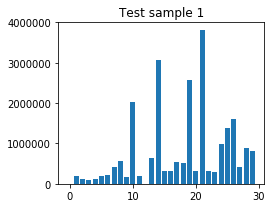

Classification result:  Fast_and_Furious_six

(Top 3: [('Fast_and_Furious_six', 30), ('Disconnect', 1), ('Jungle_Book', 1)])


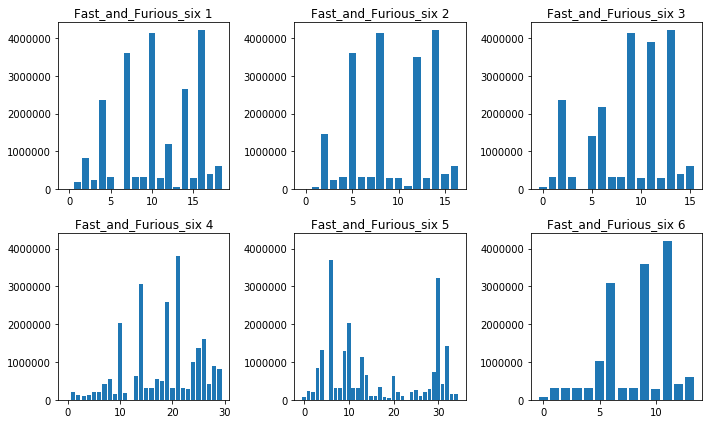

In [15]:
if __name__ == '__main__':
    main(['learn'])

    print('-' * 40)

    test_pcap = f'{DATA_PATH}/Fast_and_Furious_six/Test/Fast_and_Furious_six_Train00_40_30.pcap'
    main(['test', '-t', test_pcap])

## Conclusion

We wrote a short python program to build and train a nearest neighbor model to classify encrypted YouTube video streams using Tranalyzer.

Download the jupyter notebook for this tutorial [here](/download/data/bpb-classifier.ipynb).

If you have any questions or feedback, please do not hesitate to contact us!

# References

[1] R. Dubin, A. Dvir, O. Pele and O. Hadar, "I Know What You Saw Last Minute—Encrypted HTTP Adaptive Video Streaming Title Classification," in IEEE Transactions on Information Forensics and Security, vol. 12, no. 12, pp. 3039-3049, Dec. 2017. doi: 10.1109/TIFS.2017.2730819 https://ieeexplore.ieee.org/document/7987775